## Practical Session - Unsupervised Learning

This Practical session is about unsupervised learning. We will use the dimensionality reduction and clustering techniques presented this morning to analyze both toy examples and real images.

Please answer the questions and complete the code where you see (`XXXXXXXXXX`). 

First let's load the functions we will use

In [1]:
import numpy as np
import numpy.matlib
import math
import matplotlib.pyplot as plt
plt.close('all')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA

from scipy import linalg as LA
from scipy.stats import ortho_group
from scipy.stats import gennorm

from skimage.io import imread
from skimage.transform import resize
from skimage.transform import rescale
from skimage import img_as_bool

from mpl_toolkits.axes_grid1 import AxesGrid
from scipy.spatial.distance import dice
from skimage.measure import find_contours

from scipy.io import loadmat

# I - Dimensionnality reduction: NMF

## I - 1) Dataset

You will first work on the same face images as during the practical work 1.

Load the original images present in the files *'YaleB\_32x32.mat'*. This is a small part of the freely available Extended Yale Face Database B downloaded from http://www.cad.zju.edu.cn/home/dengcai/Data/FaceData.html. It contains 2414 cropped images resized to 32x32 pixels. Every image is represented as a vector 1x1024 and all images are stacked in a matrix called data. There are 38 subjects with around 64 near frontal images per individual under different illumination conditions. Once loaded and normalised the data, such that the pixels are between 0 and 1, you can plot images using the function *'imshow'*.

**Goal**

The goal of this part is to evaluate the performance of the dimensionality reduction techniques presented this morning for face recognition. We divide the data-set into two parts, training and test. For every dimensionality reduction technique, you will first extract a set of basis images from your training data-set. Then, you will project the test subjects in this new basis and use the nearest neighbor algorithm to evaluate the performance of the dimensionality reduction technique. 

Let's load the data and define a function to plot the faces. If you do not remember how the dataset is constituted, please refer to the previous practical work.

In [2]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1rgICXtcIAgDqSoHnNXNZMD_iNABF3RZA',
  dest_path='./YaleB_32x32.mat')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./"




x = loadmat('YaleB_32x32.mat')
data=x['fea']
d=data.shape[1] # number of pixels of the images
subjectIndex=x['gnd'] # we have one index per subject
maxValue = np.max(np.max(data)) # max intensity value
data = data/maxValue; # Scale pixels to [0,1]

Ns=len(np.unique(subjectIndex)); # Number subjects
Is=round(len(subjectIndex)/Ns) # Number images per subject (on average, not the same number for every subject)
r=int(np.sqrt(d)) # number rows of each image
c=r # number columns of each image, equal to row since images are square

print('There are', data.shape[0], 'facial images and each image has', d, 'pixels' )
print('There are', Ns, 'different subjects and each subject has on average', Is, 'images')




Xtrain, Xtest, Id_Train, Id_Test = train_test_split(data,subjectIndex,test_size=0.20,stratify=subjectIndex, random_state=44)
Xctest=Xtest-np.mean(Xtest,axis=0) # centering
Xctrain=Xtrain-np.mean(Xtrain,axis=0) # centering



def plotFaces(data,r,c,ncol=2,N=0,indeces=None,title=None):
    # data: each face is a row in data
    # r,c = number of rows and columns of each image
    # n_col = number of columns for subplots
    # N = random images to plot (used only if indeces is empty)
    # indeces = indeces of images to plot
    # title = title of the plot

   
    if indeces is None:
        if N==0:
            raise NameError('You should define either N or indeces')
        else:
            print('Use N random subjects')
            indeces=np.random.randint(0,data.shape[0],(N,1))
            
    nrow=math.ceil(len(indeces)/ncol)
    
    fig=plt.figure(figsize=(17, 6))
    plt.suptitle(title, size=16)
    for i, index in enumerate(indeces):
        fig.add_subplot(nrow, ncol, i+1)
        plt.imshow(np.resize(data[index,:],(r,c)).T,origin='upper',cmap='gray')
        plt.xticks(())
        plt.yticks(())

There are 2414 facial images and each image has 1024 pixels
There are 38 different subjects and each subject has on average 64 images


## I - 2) NNMF

Here you will test Non-negative Matrix factorization. The basis images of the training are in the matrix $W_{train}$ and the scores (or coefficients) to test the performance in $H_{train}$. The test scores are computed as $H_{test}=W_{train}^{-1}X_{test}$.

**Question**

1. Use the scikit-learn implementation to test the performance.
2. Plot the basis images and compare them with respect to the basis images obtained using PCA and ICA in the last practical work. What can you say ?
3. What about the performances of NNMF, i.e. computational time and classification accuracy ? Is it better or worse than the other methods ? Why ?
4. Do you think that it is a food idea to use a PCA before the NMF algorithm? Why?

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8737060041407867


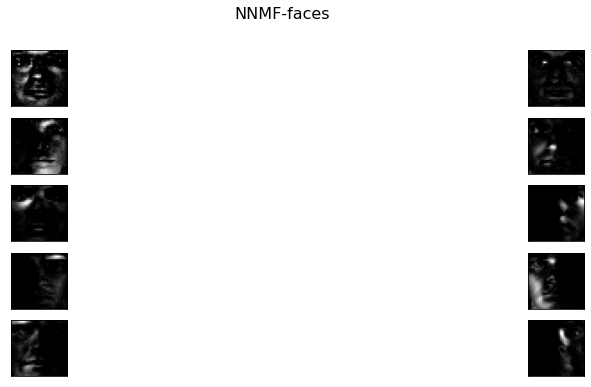

In [ ]:
# NNMF (scikit-learn implementation)
Ncomponents=100
model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
WtrainNNMF = model.fit_transform(Xtrain.T)
HtrainNNMF = model.components_

plotFaces(WtrainNNMF.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN=KNeighborsClassifier(n_neighbors=1)
NN.fit(HtrainNNMF.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

**Answer :** <br>
2. The first thing that we can notice is that the images have a really bad contrast, they are very dark in comparison with the PCA and ICA basis images. By focussing on each one, we can see that the images are more clear and we have eliminated the noise that existed. Moreover, each NNMF-face show clearly some details of the face (like ICA) without noise.
Finally, as seen in the course, we can say that NNMF works well with images.
3.Computational time : The NNMF (Ncomponents= 100) is fast compared to PCA and ICA ( In the case where we kept 99% of the variability of the data).
Accuracy : The Percentage of correct answer increased with NNMF to 0.87 . In fact, we had 0.71 with the PCA and also 0.71 with the second architecture of the ICA. This good accuracy is due to the fact that we don't have an assumption about the distribution of data, and we have non negative coefficients (images the coeffs are between 0 and 255).
4. No, i don't think it is a good idea to perform PCA before NNMF because we can obtain negative coefficients after the execution of the PCA(non positive matrix) , which will make the execution of the NNMF impossible.

Implement your own implementation in `NNMFLecture` following the lecture slides. Complete the missing lines (`XXXXXXXXXX`) 

In [ ]:
def NNMFLecture(X,r=None,N_Iter=1000,tolerance=1e-3,plot_evolution=1):
    '''
    Inputs: 
    %           X: is a [dxN] matrix. Every column (x) is an observation and every
    %           row consists of features.
    %
    %           r: size of the matrices W and H
    %
    %           (Optional) N_Iter: maximum number of iterations
    %
    %           (Optional) tolerance: convergence criteria threshold
    %
    %           (Optional) plot_evolution: plot evolution convergence criteria
    %
    % Outputs:
    %           W: is a [d x r] matrix containing the basis images in its
    %           columns
    %           
    %           H: is a [r x N] matrix containing the loadings (h) in its columns
    %           of the linear combination: x=Wh 
    %
  '''
    if r is None:
        r=X.shape[0]
        
    # Test for positive values
    if np.min(X) < 0:
        raise NameError('Input matrix X has negative values !')      

    # Size
    d,N=X.shape
   
    # Initialization
    W=np.random.rand(d,r)
    H=np.random.rand(r,N) 
    
    # parameters for convergence
    k = 0
    delta = np.inf
    eps=np.finfo(float).eps
    evolutionDelta=[]
 
    while delta > tolerance and k < N_Iter:
        
        # multiplicative method      
        
        XH=np.dot(X,H.T)
        HH=np.dot(H,H.T)
        for i in range(20):
            W = np.divide(np.multiply(W,np.dot(X,H.T)) ,np.dot(W,np.dot(H,H.T) + eps))
            #i used multiply since we need to do it term to term           
        H = np.divide(np.multiply(H,np.dot(W.T,X)),np.dot(np.dot(W.T,W),H) + eps)

        # Convergence indices
        k = k + 1           
        diff=X-np.dot(W,H)     
        #delta = np.sqrt(np.sum(diff**2)) / np.sqrt(np.sum(X**2)) # |X-WH|_2 / |X|_2
        delta = LA.norm(diff,'fro') / LA.norm(X,'fro') # sqrt(trace(diff'*diff)) / sqrt(trace(X'*X))
        evolutionDelta.append(delta)
        
        if k==1 or k%100==0:
            print('Iteration NNMF number ', k, ' out of ', N_Iter , ', delta = ', delta, ', error (norm delta): ', LA.norm(diff))
     
    if k==N_Iter:
        print('Maximum number of iterations reached ! delta = ', delta)
    else:
        print('Convergence achieved ( delta = ', delta, ') in ', k, ' iterations')
    
    if plot_evolution==1:
        plt.figure(figsize=(6, 6))
        plt.plot(range(k),evolutionDelta,'bx--', linewidth=4, markersize=12)  
        plt.title('Evolution of error - NNMF')
        plt.show()
    
    return W,H

Iteration NNMF number  1  out of  300 , delta =  0.5304971707014977 , error (norm delta):  273.0770671148181
Iteration NNMF number  100  out of  300 , delta =  0.1577141524231548 , error (norm delta):  81.1844446394762
Iteration NNMF number  200  out of  300 , delta =  0.15008131986523246 , error (norm delta):  77.25539158545197
Iteration NNMF number  300  out of  300 , delta =  0.14761657104023942 , error (norm delta):  75.9866451764678
Maximum number of iterations reached ! delta =  0.14761657104023942


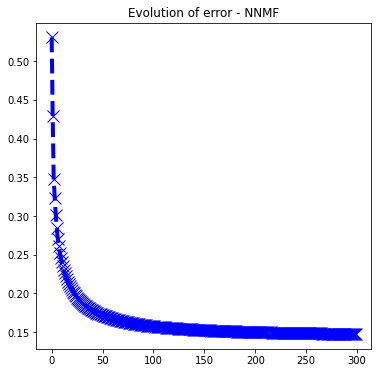

NNMF uses  100  features
Percentage of correct answer using NNMF is  0.8612836438923396


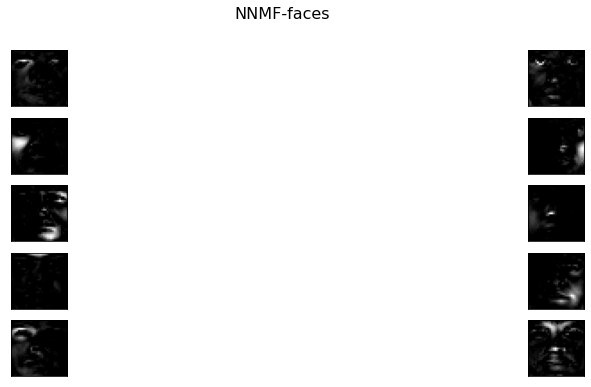

In [ ]:
# NNMF (your own implementation)
Ncomponents=100
Wtrain_nnmf,Htrain_nnmf = NNMFLecture(Xtrain.T,r=Ncomponents,N_Iter=300,tolerance=1e-3,plot_evolution=1)
plotFaces(Wtrain_nnmf.T,r,c,ncol=2,indeces=np.arange(0,10,1),title='NNMF-faces') 

# to invert the matrix you can use the function LA.pinv
Htest_nnmf = np.dot(LA.pinv(Wtrain_nnmf),Xtest.T)

print('NNMF uses ', Ncomponents, ' features')

# Score
NN.fit(Htrain_nnmf.T,Id_Train.ravel())
print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))

## I-3) ICA and NNMF in the presence of noise

We will now compare ICA and NNMF results in the presence of noise within the dataset. Please note that during the class on ICA, the dataset $X$ was assumed to be noiseless: we were looking for a decomposition such that $X = AS$, and not $X = AS + N$, where $N$ would be a noise term.

1. How do you think that ICA might behave in the presence of noise? You might in particular consider the case of a Gaussian noise N.
2. On the other hand, do you think that NNMF behaves better? If so, for what kind of noises?

In the following, we will try to compare the behavior of ICA and NNMF in the presence of noise. Do the following:
- add some Gaussian noise to both the training and the testing dataset.
- apply both NNMF and ICA (the second architecture you implemented in the previous practical work) on the noisy dataset. For both, you can use 250 features.
- use the NN algorithm to classify the images from the features extracted from ICA and NNMF.

Redo the same for different noise levels. Plot a curve of the classification accuracy when either ICA or NNMF are used as pre-processing steps. Comment your results.

**Answer 1** <br>
During the class, we only considered a noiseless dataset. But by doing some researchs, i found out that ICA is a good method to use with structured noise.<br>
**Answer 2**<br>
I think that the NNMF give better results with a certain type of noise.
As seen in the graph, we can say that the NNMF behave better in the presence of Gaussian noise(especially with low values of sigma). In fact it is clear that the score obtained with the NNMF is higher than the score obtained with ICA.

In [7]:
sigmaTab = np.array([0,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5])
scoreNMF = np.zeros(len(sigmaTab))
scoreICA = np.zeros(len(sigmaTab))
scoreICA1 = np.zeros(len(sigmaTab))

for i in range(len(sigmaTab)):
    # Data generation
    noise = np.random.normal(0,sigmaTab[i],Xtrain.shape)
    noisetest= np.random.normal(0,sigmaTab[i],Xtest.shape)
    XtrainNoise=Xtrain+np.abs(noise)
    XtestNoise=Xtest+np.abs(noisetest)
    XctrainNoise=XtrainNoise-np.mean(XtrainNoise,axis=0)
    XctestNoise=XtestNoise-np.mean(XtestNoise,axis=0)
    ##################
    # NMF
    Ncomponents=250
    model = NMF(init='random', solver='mu', n_components=Ncomponents, tol=1e-3,max_iter=300, random_state=0)
    WtrainNNMF = model.fit_transform(XtrainNoise.T)
    HtrainNNMF = model.components_

    # to invert the matrix you can use the function LA.pinv
    Htest_nnmf = np.dot(LA.pinv(WtrainNNMF),XtestNoise.T)

    print('NNMF uses ', Ncomponents, ' features')

    # Score
    NN=KNeighborsClassifier(n_neighbors=1)
    NN.fit(HtrainNNMF.T,Id_Train.ravel())
    print('Percentage of correct answer using NNMF is ', NN.score(Htest_nnmf.T,Id_Test))
    scoreNMF[i] = NN.score(Htest_nnmf.T,Id_Test)

    ##################
    ## ICA
    # Second architecture (scikit-learn implementation)
    
    ICA= FastICA(whiten=True, fun='exp', max_iter=20000, tol=0.00001, random_state=1,n_components=250)
    S=ICA.fit_transform(XctrainNoise.T)
    W=ICA.components_.T
    
    #...
    pca = PCA(random_state=1) # by fixing the random_state we are sure that results are always the same
    YpcaTrain=pca.fit_transform(XctrainNoise)
    UpcaTrain=pca.components_.T
    L = UpcaTrain [ : , : 250] 
    print(L.shape)
    Y_train = XctrainNoise.dot(L)
    Y_test = XctestNoise.dot(L)
    Y_train_ICA2=np.dot(W,Y_train.T)
    Y_test_ICA2 = np.dot(W, Y_test.T)
    
    
    NN.fit(Y_train_ICA2,Id_Train.ravel())
    print('Percentage of correct answer using ICA is ', NN.score(Y_test_ICA2.T,Id_Test.ravel()))
    scoreICA[i] = NN.score(Y_test_ICA2.T,Id_Test.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  ConvergenceWarning,


NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8881987577639752
(1024, 250)
Percentage of correct answer using ICA is  0.039337474120082816
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8985507246376812
(1024, 250)
Percentage of correct answer using ICA is  0.033126293995859216
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8778467908902692
(1024, 250)
Percentage of correct answer using ICA is  0.018633540372670808
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8861283643892339
(1024, 250)
Percentage of correct answer using ICA is  0.033126293995859216
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.8488612836438924
(1024, 250)
Percentage of correct answer using ICA is  0.028985507246376812
NNMF uses  250  features
Percentage of correct answer using NNMF is  0.7701863354037267
(1024, 250)
Percentage of correct answer using ICA is  0.033126293995859216
NNMF uses  250  

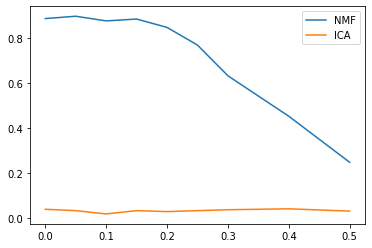

In [8]:
plt.figure(),plt.plot(sigmaTab,scoreNMF)
plt.plot(sigmaTab,scoreICA)
plt.legend(['NMF','ICA'])

# II - Clustering: K-means

We will now work on the K-means algorithm. First, the K-means algorithm will be used to cluster the toy examples datasets of the first practical work. Then, it will be used to segment real images.

## II - 1) Toy examples

Let us first define the toy examples.

In [ ]:
def generate_scenario(scenario=3, n_samples0 = 100, n_samples1 = 30):

    y = np.concatenate((np.zeros([n_samples0,1]) , np.ones([n_samples1,1])) , axis=0)

    if scenario == 1: 
        # Separate Gaussian
        mean0 = [2, 3]
        mean1 = [12, 14]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = 2 ** 2 * np.eye(2)
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
    elif scenario == 2:
        # Overlapping Gaussian
        mean0 = [2, 3]
        mean1 = [5, 7]
        cov0 = [[1, 1.5], [1.5 ,3]]
        cov1 = [[2, 3], [3 ,6]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 3:
        # Overlapping Gaussian
        mean0 = [0, 0]
        mean1 = [0, 0]
        cov0 = [[50, 15], [15, 6]]#cov0 = [[50, 4], [4, 2]]
        cov1 = [[2, 0], [0 ,50]]#cov1 = [[2, 0], [0 ,50]]
        X0 = np.random.multivariate_normal(mean0, cov0, n_samples0, check_valid='raise')
        X1 = np.random.multivariate_normal(mean1, cov1, n_samples1, check_valid='raise')
        
        
    elif scenario == 4:
        # Circles
        # 1 circle
        angle0=np.linspace(0, 2 * np.pi, n_samples0);
        X0=np.vstack((8*np.cos(angle0) , 8*np.sin(angle0))).T
        
        # 2 circle
        angle1=np.linspace(0, 2 * np.pi, n_samples1);
        X1=np.vstack((2*np.cos(angle1) , 2*np.sin(angle1))).T

    return X0,X1,y

def plotResults(X0=None,X1=None,y=None,U=None,Y=None,const=1,title=''):

    X=np.concatenate((X0,X1),axis=0)
    
    N0=np.sum(y==0)
    N1=np.sum(y==1)
    
    fig=plt.figure(figsize=(17, 6))
    
    ax  = fig.add_subplot(1, 3, 1)
    plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
    plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
    if U is not None:
        average=X.mean(axis=0)
        sd=LA.norm(X.std(axis=0))
        u0=U[:,0]*const*sd;
        u1=U[:,1]*const*sd;
        plt.plot([average[0]-u0[0], average[0]+u0[0]],[average[1]-u0[1], average[1]+u0[1]], c='g',linewidth=4, label='C 1' )
        plt.plot([average[0]-u1[0], average[0]+u1[0]],[average[1]-u1[1], average[1]+u1[1]], c='k',linewidth=4, label='C 2' )
        plt.title('Original data and components')
    else:
        plt.title('Original data')
    plt.legend()
    
    ax  = fig.add_subplot(1, 3, 2)
    plt.scatter(Y[np.where(y == 0)[0],0], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],0], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    ax.set_title(title + '\n Scores on 1st component')
    
    ax  = fig.add_subplot(1, 3, 3)
    plt.scatter(Y[np.where(y == 0)[0],1], np.zeros((N0,1)), c='r', s=3, marker='o', label='Class 0')
    plt.scatter(Y[np.where(y == 1)[0],1], np.zeros((N1,1)), c='b', s=3, marker='x', label='Class 1')
    plt.legend()
    plt.title('Scores on 2nd component')
    
    plt.show()
    
    
def frontiere(model, X, y, step=50):

    labels = np.unique(y)
 
    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array( model.predict(np.c_[xx.ravel(), yy.ravel() ]) )
    z = z.reshape(xx.shape)
   
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", cmap='RdBu')
    
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
    plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1') 
    
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    

Now, create the data we will use.

#Scenario 1

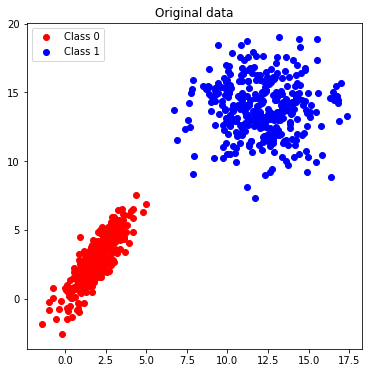

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 1
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

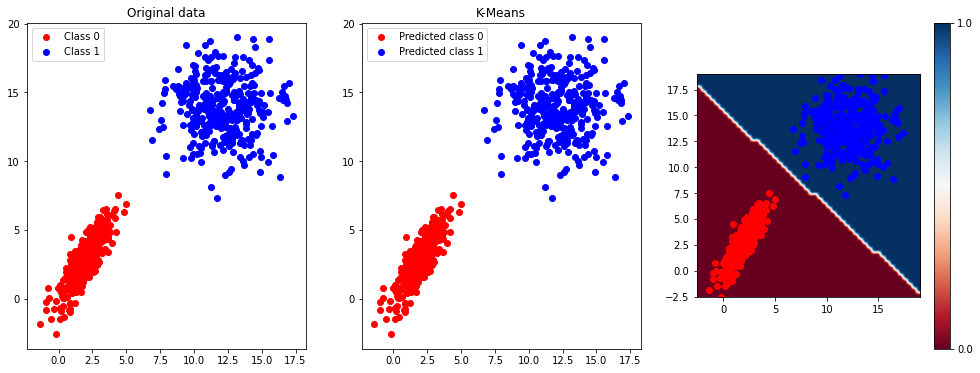

In [ ]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

* The Kmeans method works well in this case (K=2) because the data is seperable .

#Scenario 2

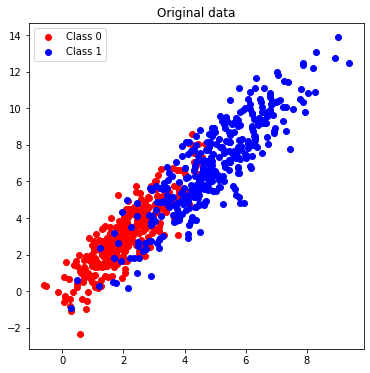

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 2
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

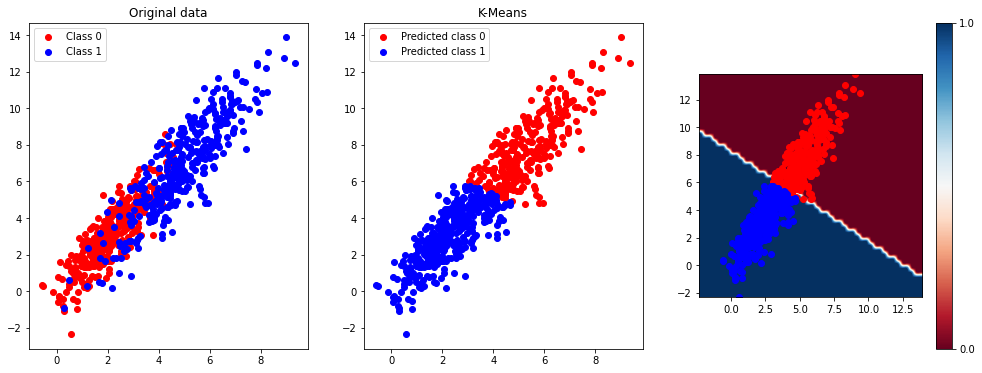

In [ ]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

* For this scenario, the Kmeans missclassified too many points. it is normal since the data is overlapping 

#Scenario 3

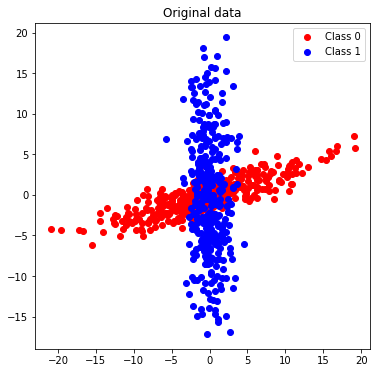

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 3
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

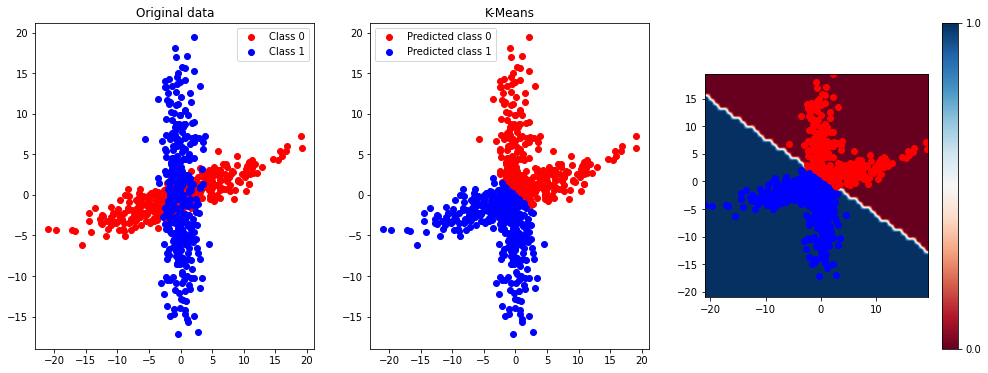

In [ ]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

* For this scenario, the Kmeans missclassified too many points. it is normal since the data is overlapping and the kmeans can't distinguish between the  2 classes 

#Scenario 4

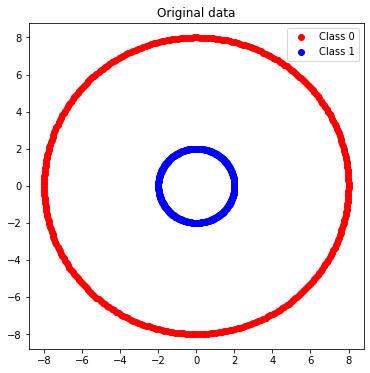

In [ ]:
## Choose the scenarioIndex (value between 1 and 4)
scenarioIndex = 4
##

X0,X1,y = generate_scenario(scenario=scenarioIndex, n_samples0 = 350, n_samples1 = 350)
X=np.concatenate((X0,X1),axis=0)

plt.figure(figsize=(6, 6))
plt.scatter(X0[:,0],X0[:,1],c='r', label='Class 0')
plt.scatter(X1[:,0],X1[:,1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()
plt.show()

Use the K-means to find the different clusters in the dataset. K-means will be used on X and we will check whether it can well separate the two classes. 



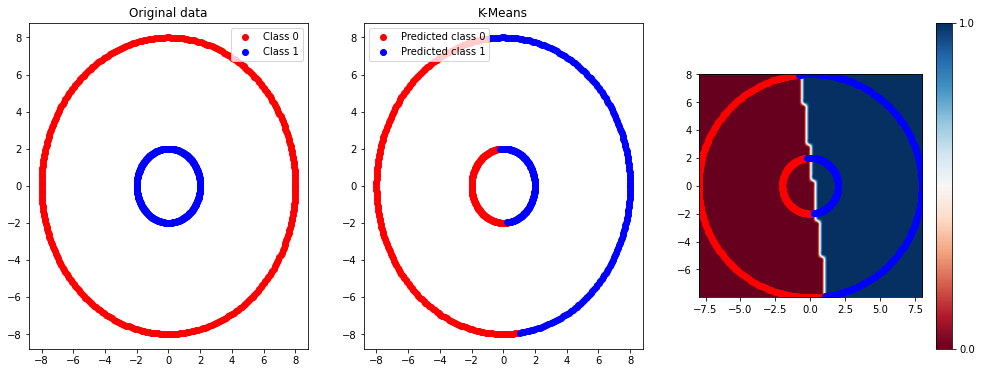

In [ ]:
## K-means
Ncluster= 2 # choose a number of clusters
kmeans=KMeans(n_clusters=Ncluster) 
yKmeans=kmeans.fit_predict(X)

plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

plt.subplot(133)
frontiere(kmeans, X, y, step=50)

plt.show()

* For this Scenario, the Kmeans gives bad results and can't seperate between the two classes.


**Question:**
1. Does it work well in all scenarios ? Why ? Is it always easy to define the correct number of clusters ?
**Answer:** Please check the comments after each result.
Defining the right number of clusters depends on the data, if it is an easy example then we can determine the right number of cluster.Most of the times, we don't have an easy example so defining the right number of clusters is hard

Now, implement your own K-means using the Lloyd's algorithm.

In [ ]:
#function for euclidian distance :
def dist_euc(p1, p2):
    return np.linalg.norm(np.array(p1)-np.array(p2))

In [ ]:
#This function is made to calculate the new centers after assigning the data using the mean
def compute_mean(clusters):
  c = []
  for cluster in clusters:
      c.append(np.mean(cluster))
  return c

In [ ]:
import random
def KMeansLecture(X,K=2,tol=1e-4):
    #Initialisation of means
    muTab =[]
    for i in range(K):
      muTab.append(random.choice(X).mean())
    #print(muTab)
    iteration=0
    while (True):
      iteration=iteration+1
      #Creating a list containing a list of points , each one represent one cluster
      yKmeans=[ [] for i in range(K)]
      for pt in X:
        dist = []
        for i in range(len(muTab)):
           dist.append(dist_euc(pt, muTab[i]))
        yKmeans[dist.index(min(dist))].append(list(pt))
        newmuTab = compute_mean(yKmeans) #determining the new centers
      print(yKmeans)
      # STOPPING Criteria as said in the course : when the assignment step becomes unchanged
      #Creating copies of the last c enters and clusters 
      muTab_copy = [str(elem) for elem in muTab]
      newmuTab_copy = [str(elem) for elem in newmuTab]
      #sorting so we can compare
     
      if( set([tuple(a) for a in muTab_copy]) == set([tuple(a) for a in newmuTab_copy] )) :
        print("the number of iterations is :",iteration)
        break
      #if it is not the case ! we continue with the new clusters
      muTab=newmuTab
    return yKmeans,muTab

**My KmeansLecture algorithm returns a list of lists (yKmeans), each list contains the points of a class and muTab that contains the last centers**

Now, test your K-means algorithm.

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[[8.0, 0.0], [7.998703545905327, 0.14401939008880751], [7.994814603819612, 0.2879921015456168], [7.988334434201579, 0.43187147086760547], [7.979265137361835, 0.5756108648053995], [7.967609652782137, 0.7191636954775396], [7.953371758162663, 0.8624834354702442], [7.936556068197606, 1.005523632917573], [7.917168033079495, 1.148237926557105], [7.895213936732708, 1.2905800607562512], [7.870700894776772, 1.4325039005043294], [7.843636852220091, 1.5739634463655467], [7.814030580884861, 1.7149128493880372], [7.781891676564009, 1.8553064259641288], [7.747230555911061, 1.9950986726370163], [7.710058453063966, 2.1342442808490496], [7.67038741600396, 2.272698151626848], [7.6282303026506515, 2.4104154101984885], [7.583600776694598, 2.5473514205380248], [7.536513303168716, 2.6834617998326293], [7.4869831437599705, 2.8187024328676604], [7.435026351862856, 2.9530294863250024], [7.380659767376272, 3.0863994229900356], [7.323901011245488, 3.218769015862635], [7.264768479750951, 3.3500953621676293], [7.

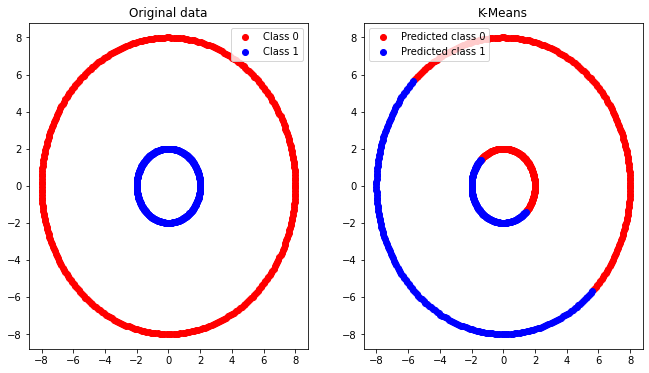

In [ ]:
## K-means
Ncluster= 2 # choose a number of clusters
yKmeans,muTab = KMeansLecture(X,K=Ncluster,tol=1e-4)
#i made the next modification to be able to plot the data since my function Kmeanslecture give back 2 lists,
#each list containing the points of a class
zero=yKmeans[0]
x_0=[zero[i][0] for i in range(len(zero))]
y_0=[zero[i][1] for i in range(len(zero))]
one=yKmeans[1]
x_1=[one[i][0] for i in range(len(one))]
y_1=[one[i][1] for i in range(len(one))]
plt.figure(figsize=(17, 6))
plt.subplot(131)
plt.scatter(X[np.where(y == 0)[0],0],X[np.where(y == 0)[0],1],c='r', label='Class 0')
plt.scatter(X[np.where(y == 1)[0],0],X[np.where(y == 1)[0],1],c='b', label='Class 1')
plt.title('Original data')
plt.legend()

plt.subplot(132)
plt.scatter(x_0,y_0,c='r', label='Predicted class 0')
plt.scatter(x_1,y_1,c='b', label='Predicted class 1')
#plt.scatter(X[np.where(yKmeans == 0)[0],0],X[np.where(yKmeans == 0)[0],1],c='r', label='Predicted class 0')
#plt.scatter(X[np.where(yKmeans == 1)[0],0],X[np.where(yKmeans == 1)[0],1],c='b', label='Predicted class 1')
plt.title('K-Means')
plt.legend()

## II-2) K-means for skin lesion segmentation


In this section, you will use the K-means to segment skin lesion images. You will use two images from the ISIC dataset (www.isic-archive.com), one nevus and one melanoma with their respetive manual segmentation. 

**Goal**

The goal of this section is to delineate the contours (i.e. segment) of the skin lesions using k-means. 

Let's first load the data. The images are rescaled so that the computations are faster.

(-0.5, 374.5, 280.5, -0.5)

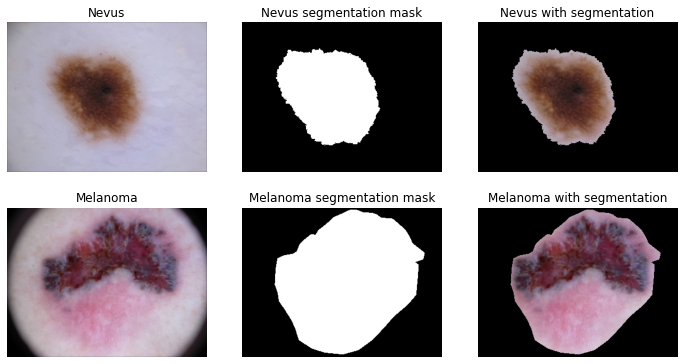

In [ ]:
if 'google.colab' in str(get_ipython()):
  from google_drive_downloader import GoogleDriveDownloader as gdd
  gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
  dest_path='./data/nevus.jpg')
  gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
  dest_path='./data/nevus-seg.jpg')
  gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
  dest_path='./data/melanoma.jpg')
  gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
  dest_path='./data/melanoma-seg.png')
else:
  print('You are not using Colab. Please define working_dir with the absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
Working_directory="./data/" 




# Nevus
nevus = imread(Working_directory + 'nevus.jpg')
nevus=nevus[2:-2,2:-2,:] # remove border (it contains artifacts)
nevusMask = imread(Working_directory + 'nevus-seg.jpg')
nevusMask=nevusMask[2:-2,2:-2] # remove border (it contains artifacts)
# We rescale to speed up computations
nevus = rescale(nevus, 0.25,multichannel=True, anti_aliasing=True)
# We need all these options to preserve the binary values
nevusMask = rescale(nevusMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
nevusMask_boolean = (nevusMask/255).astype(np.uint8) # To get uint8
nevusMask_expand = np.expand_dims(nevusMask_boolean, axis=2) # To have a 3 channels boolean mask

# Melanoma
melanoma = imread(Working_directory + 'melanoma.jpg')
melanoma=melanoma[2:-2,2:-2,:] # remove border (it contains artifacts)
melanomaMask = imread(Working_directory + 'melanoma-seg.png')
melanomaMask=melanomaMask[2:-2,2:-2] # remove border (it contains artifacts)
melanoma = rescale(melanoma, 0.25,multichannel=True, anti_aliasing=True)
melanomaMask = rescale(melanomaMask, 0.25, anti_aliasing=False, order=0,  preserve_range=True)
melanomaMask_boolean = (melanomaMask/255).astype(np.uint8) 
melanomaMask_expand = np.expand_dims(melanomaMask_boolean, axis=2)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (2, 3),
                axes_pad = 0.5)
grid[0].imshow(nevus)
grid[0].set_title('Nevus')
grid[0].axis('off')
grid[1].imshow(nevusMask_boolean,cmap='gray')
grid[1].set_title('Nevus segmentation mask')
grid[1].axis('off')
grid[2].imshow(nevusMask_expand*nevus)
grid[2].set_title('Nevus with segmentation')
grid[2].axis('off')
grid[3].imshow(melanoma)
grid[3].set_title('Melanoma')
grid[3].axis('off')
grid[4].imshow(melanomaMask_boolean,cmap='gray')
grid[4].set_title('Melanoma segmentation mask')
grid[4].axis('off')
grid[5].imshow(melanomaMask_expand*melanoma)
grid[5].set_title('Melanoma with segmentation')
grid[5].axis('off')



**Questions**

1. Before running K-means, please answer this question. How many classes $K$ should you look for ? Would you use the same $K$ for both images ? Why ?

2. Run the following code for both images. Try to choose different channels (among the channels Red, Green and Blue) and different number of clusters $K$. Which is the best choice in terms of channel and number of classes ? You can use the [Dice score](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to quantitatively compare your mask and the manual segmentation. Comment the results with respect to the previous answer.

The dice score (or dice similarity) between two binary masks is defined as $\frac{2TP}{2TP + FP + FN}$ and it ranges between 0 (completely different) and 1 (perfectly equal).

3. Propose a way to automatically select the class (or unions of classes) representing the skin lesion and not the skin. (You don't need to implement it, just explain how you would do it).

4. In K-means, we recompute the average at each iteration. The average is not constrained to be one of the original observations. It is usually an *interpolation* of the original observations. How would you change the Lloyd's algorithm to constrain the average to always be one of the original observations ?

#**Answer Q1:**
* Nevus legion : If we look at the nevus lesion, we can see that we have 2 different regions.logically, choosing K=2 is the best solution.This point of view can be confirmed while seeing the histogram of one of the channels of the image (we can see 2 peaks, one near 0 and one near 1) .

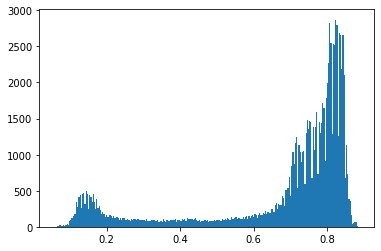

In [ ]:
plt.show(plt.hist(nevus[:,:,2] .ravel(), bins = 256))

* Melanoma lesion: This lesion is different from the Nevus lesion.In fact, we can see that the lesion is bigger than just the dark spot so we got 3 different regions.In this case, we can consider choosing K=3 and then combine the 2 clusters of the legion. This point of view can be confirmed by visualizing the histogram of a channel of the image(we can see here 3 peaks).

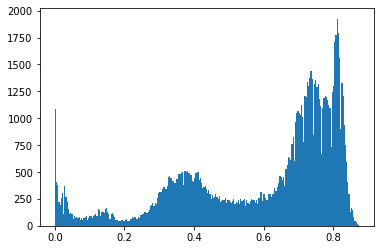

In [ ]:
plt.show(plt.hist(melanoma[:,:,0] .ravel(), bins = 256))

# **Answer Q2 :**

To find the best number of clusters K and the best channel for the segmentation, i am going to check the best dice score given while changing the channel (0,1,2) for a given value of K(i will vary K at each section).<br>
As we can see we have a section for the Nevus lesion and a section for the Melanoma lesion .
In each section, we go trough different values of K and see the best dice score obtained .

#Nevus Lesion

#K=2

##Channel 0

The dice score is  0.6726887363746468


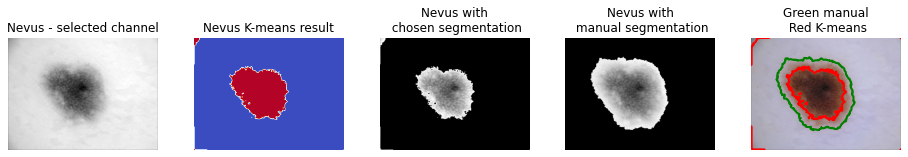

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0
##
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))

##Channel 1

The dice score is  0.7887271543505557


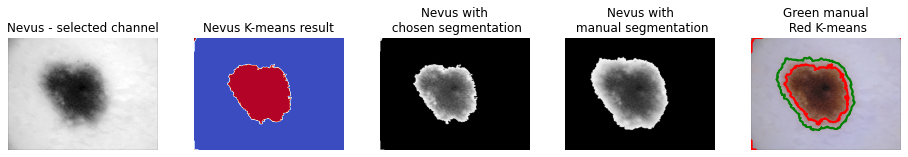

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=1
##
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))

##Channel 2

The dice score is  0.8298922800718133


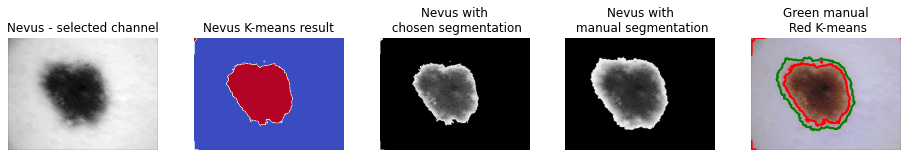

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(nevusMask_boolean, 0.5)

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(nevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(mask*nevusB,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(nevusMask_boolean*nevusB,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))

##Conclusion
$=>$ For K=2, the best result we obtained is with the blue channel. The dice score is equal to 0.82

#K=3

##Channel 0 :

0.13268690992600152
0.5018765517639587
0.5131752135649211
0.2696697507935436
0.28102639415820174
0.785068778833393
The dice score is  0.785068778833393


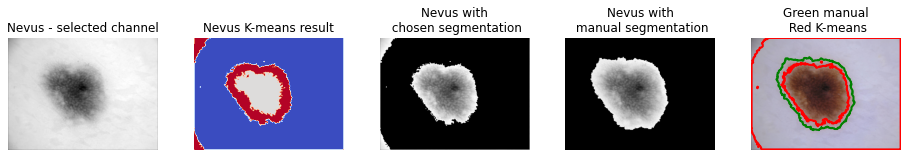

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0

##
max=0
bestmask_nev = nevus[:,:,0] 
bestmask_manual = nevus[:,:,0] 
#mask = nevus[:,:,0]
bestindex1 = 0
bestindex2 = 0
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(3):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(nevusMask_boolean, 0.5)
    print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestnevusB = nevusB
      bestlabels = labels
      bestmask_nev = mask*nevusB
      bestmask_manual = nevusMask_boolean*nevusB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(3):
  for index2 in range(index1+1,3):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(nevusMask_boolean, 0.5)
      print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        bestmask = mask
        max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestnevusB = nevusB
        bestlabels = labels
        bestmask_nev = mask*nevusB
        bestmask_manual = nevusMask_boolean*nevusB
        bestindex1 = index1
        bestindex2 = index2
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(bestnevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_nev,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(bestmask_manual,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Channel 1

0.07555497857977411
0.6392039487502625
0.5199128727781214
0.270747233702173
0.23071821349116395
0.8849091387937845
The dice score is  0.8849091387937845


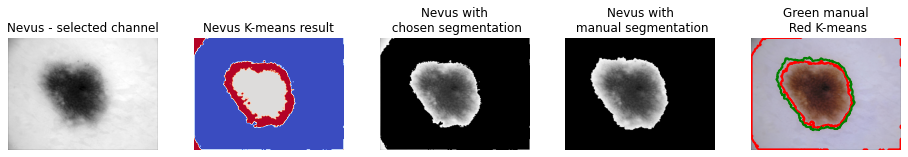

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=1

##
max=0
bestmask_nev = nevus[:,:,0] 
bestmask_manual = nevus[:,:,0] 
#mask = nevus[:,:,0]
bestindex1 = 0
bestindex2 = 0
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(3):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(nevusMask_boolean, 0.5)
    print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestnevusB = nevusB
      bestlabels = labels
      bestmask_nev = mask*nevusB
      bestmask_manual = nevusMask_boolean*nevusB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(3):
  for index2 in range(index1+1,3):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(nevusMask_boolean, 0.5)
      print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        bestmask = mask
        max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestnevusB = nevusB
        bestlabels = labels
        bestmask_nev = mask*nevusB
        bestmask_manual = nevusMask_boolean*nevusB
        bestindex1 = index1
        bestindex2 = index2
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(bestnevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_nev,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(bestmask_manual,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Channel 2

0.46278152095133274
0.04782732718455829
0.7263478645500565
0.19114403179153538
0.8993907712413276
0.2883534806169237
The dice score is  0.8993907712413276


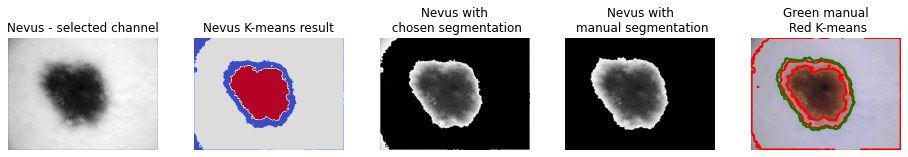

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2

##
max=0
bestmask_nev = nevus[:,:,0] 
bestmask_manual = nevus[:,:,0] 
#mask = nevus[:,:,0]
bestindex1 = 0
bestindex2 = 0
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(3):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(nevusMask_boolean, 0.5)
    print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestnevusB = nevusB
      bestlabels = labels
      bestmask_nev = mask*nevusB
      bestmask_manual = nevusMask_boolean*nevusB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(3):
  for index2 in range(index1+1,3):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(nevusMask_boolean, 0.5)
      print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        bestmask = mask
        max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestnevusB = nevusB
        bestlabels = labels
        bestmask_nev = mask*nevusB
        bestmask_manual = nevusMask_boolean*nevusB
        bestindex1 = index1
        bestindex2 = index2
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(bestnevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_nev,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(bestmask_manual,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Conclusion
$=>$ For K=3, the best result we obtained is with the blue channel. The dice score is equal to 0.89

#K=4

##Channel 0

0.0189288778961183
0.4655621301775148
0.46196833281589567
0.3009445802232644
0.1978193503959601
0.20130462703214247
0.7411408915668214
The dice score is  0.7411408915668214


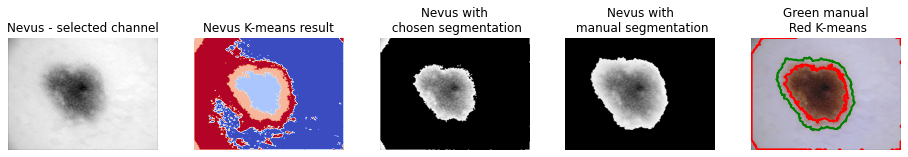

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0

##
max=0
bestmask_nev = nevus[:,:,0] 
bestmask_manual = nevus[:,:,0] 
#mask = nevus[:,:,0]
bestindex1 = 0
bestindex2 = 0
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 4 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(4):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(nevusMask_boolean, 0.5)
    print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestnevusB = nevusB
      bestlabels = labels
      bestmask_nev = mask*nevusB
      bestmask_manual = nevusMask_boolean*nevusB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(4):
  for index2 in range(index1+1,4):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(nevusMask_boolean, 0.5)
      print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        bestmask = mask
        max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestnevusB = nevusB
        bestlabels = labels
        bestmask_nev = mask*nevusB
        bestmask_manual = nevusMask_boolean*nevusB
        bestindex1 = index1
        bestindex2 = index2
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(bestnevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_nev,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(bestmask_manual,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Channel 1

0.6054458375934995
0.0
0.49056818181818185
0.21071210135430318
0.2481144974198386
0.8561525876173254
0.1946216441629286
The dice score is  0.8561525876173254


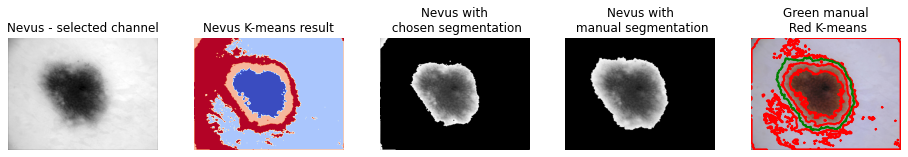

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=1

##
max=0
bestmask_nev = nevus[:,:,0] 
bestmask_manual = nevus[:,:,0] 
#mask = nevus[:,:,0]
bestindex1 = 0
bestindex2 = 0
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 4 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(4):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(nevusMask_boolean, 0.5)
    print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestnevusB = nevusB
      bestlabels = labels
      bestmask_nev = mask*nevusB
      bestmask_manual = nevusMask_boolean*nevusB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(4):
  for index2 in range(index1+1,4):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(nevusMask_boolean, 0.5)
      print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        bestmask = mask
        max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestnevusB = nevusB
        bestlabels = labels
        bestmask_nev = mask*nevusB
        bestmask_manual = nevusMask_boolean*nevusB
        bestindex1 = index1
        bestindex2 = index2
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(bestnevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_nev,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(bestmask_manual,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Channel 2

0.1867113103274468
0.6867683575736077
0.42469077351009055
0.0
0.5423208833191033
0.38977786886538124
0.8755966713133105
The dice score is  0.8755966713133105


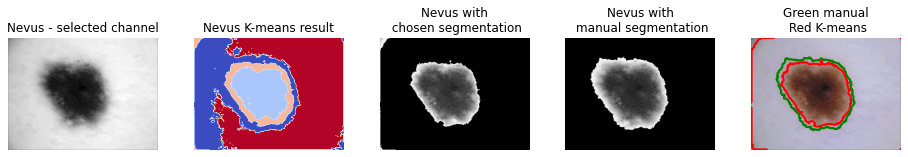

In [ ]:
## NEVUS
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2

##
max=0
bestmask_nev = nevus[:,:,0] 
bestmask_manual = nevus[:,:,0] 
#mask = nevus[:,:,0]
bestindex1 = 0
bestindex2 = 0
nevusB = nevus[:,:,channel] 

# Select the number of cluster K to look for 
K= 4 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(nevusB.reshape(-1,1))
labels=np.reshape(labels,(nevusB.shape[0],nevusB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(4):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(nevusMask_boolean, 0.5)
    print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestnevusB = nevusB
      bestlabels = labels
      bestmask_nev = mask*nevusB
      bestmask_manual = nevusMask_boolean*nevusB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(4):
  for index2 in range(index1+1,4):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(nevusMask_boolean, 0.5)
      print(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        bestmask = mask
        max = 1-dice(nevusMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestnevusB = nevusB
        bestlabels = labels
        bestmask_nev = mask*nevusB
        bestmask_manual = nevusMask_boolean*nevusB
        bestindex1 = index1
        bestindex2 = index2
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(bestnevusB,cmap='gray')
grid[0].set_title('Nevus - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Nevus K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_nev,cmap='gray')
grid[2].set_title('Nevus with\n chosen segmentation')
grid[2].axis('off')
grid[3].imshow(bestmask_manual,cmap='gray')
grid[3].set_title('Nevus with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(nevus)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

# Compute the dice score between your mask and the manual segmentation 
print('The dice score is ', 1-dice(nevusMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Conclusion
$=>$ For K=4, the best result we obtained is with the blue channel. The dice score is equal to 0.87. Since the best result is worst than the case K=3, we will not detail the further values of K.

#General conclusion for the Nevus Lesion : 

Unlike what i said in the previous question, the best obtained result is with 3 clusters (K=3) while using the blue channel. In fact, this configuration (channel=blue & K=3) gives a dice score equal to 0.89 which is quite high.

#Melanoma lesion :

#K=2

##Channel 0

The dice score is  0.503777820829867


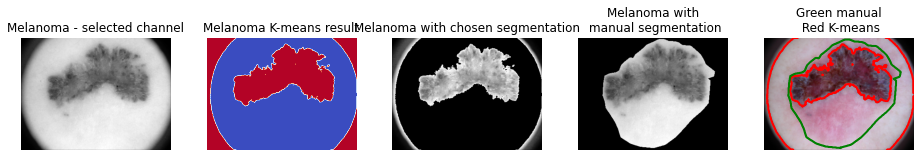

In [ ]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0
##
melanomaB = melanoma[:,:,channel]


# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))

##Channel 1

The dice score is  0.4852768152147635


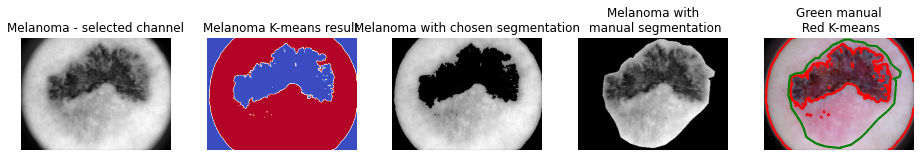

In [ ]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=1
##
melanomaB = melanoma[:,:,channel]


# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))

##Channel 2

The dice score is  0.474517776096823


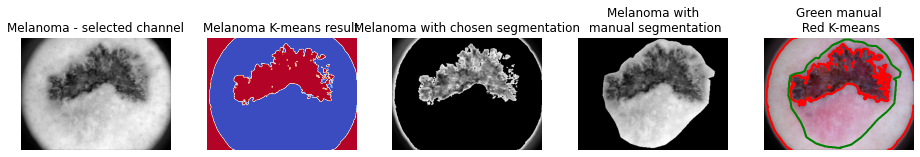

In [ ]:
## MELANOMA
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2
##
melanomaB = melanoma[:,:,channel]


# Select the number of cluster K to look for 
K= 2 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1
index =1
mask=labels==index ## choose which label should be

contourMask = find_contours(mask, 0.5)
contourManual = find_contours(melanomaMask_boolean, 0.5)

fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(labels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(mask*melanomaB,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')

print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))

##Conclusion : 
$=>$For K=2, the best result we obtained is with the red channel. The dice score is equal to 0.5

#K=3

##Channel 0

0.013048405374777361
0.47467941751793086
0.5827727725296874
0.4478122594340723
0.534318716811737
0.7023211855943052
The dice score is  0.7023211855943052


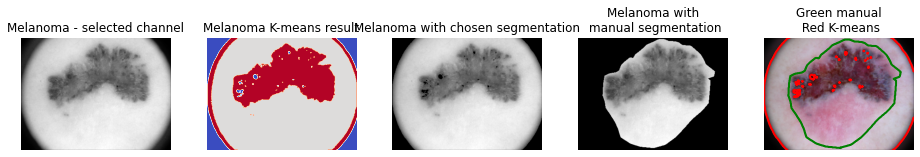

In [ ]:
##Melanoma
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0

##
max=0
bestmelanomaB = melanoma[:,:,0] 
bestlabels = melanoma[:,:,0] 
bestmask_mel = melanoma[:,:,0] 
bestmask_manual = melanoma[:,:,0] 
bestmask = melanoma[:,:,0]
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(3):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(melanomaMask_boolean, 0.5)
    print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestmelanomaB = melanomaB
      bestlabels = labels
      bestmask_mel = mask*melanomaB
      bestmask_manual = melanomaMask_boolean*melanomaB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(3):
  for index2 in range(index1+1,3):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(melanomaMask_boolean, 0.5)
      print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestmask = mask
        bestmelanomaB = melanomaB
        bestlabels = labels
        bestmask_mel = mask*melanomaB
        bestmask_manual = melanomaMask_boolean*melanomaB

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_mel,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))


##Channel 1

0.30171070156711977
0.5079069767441861
0.4254558275410497
0.5458056178494051
0.49611279682381537
0.7007364554986775
The dice score is  0.7007364554986775


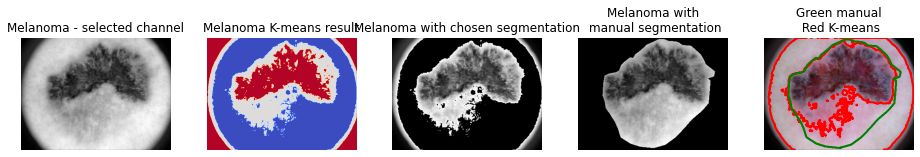

In [ ]:
##Melanoma
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=1
##
max=0
bestmelanomaB = melanoma[:,:,0] 
bestlabels = melanoma[:,:,0] 
bestmask_mel = melanoma[:,:,0] 
bestmask_manual = melanoma[:,:,0] 
bestmask = melanoma[:,:,0]
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(3):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(melanomaMask_boolean, 0.5)
    print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestmelanomaB = melanomaB
      bestlabels = labels
      bestmask_mel = mask*melanomaB
      bestmask_manual = melanomaMask_boolean*melanomaB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(3):
  for index2 in range(index1+1,3):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(melanomaMask_boolean, 0.5)
      print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestmask = mask
        bestmelanomaB = melanomaB
        bestlabels = labels
        bestmask_mel = mask*melanomaB
        bestmask_manual = melanomaMask_boolean*melanomaB

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_mel,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))


##Channel 2

0.4109776738937696
0.36809127222410776
0.41518641421042357
0.5983614065441962
0.5759964273752373
0.5493154798965711
The dice score is  0.5983614065441962


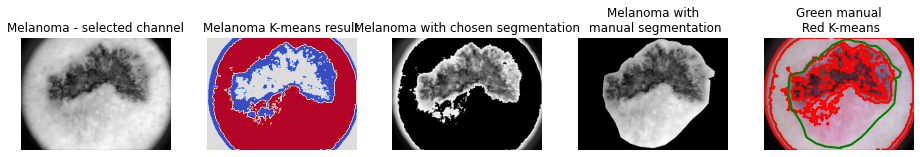

In [ ]:
##Melanoma
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2

##
max=0
bestmelanomaB = melanoma[:,:,0] 
bestlabels = melanoma[:,:,0] 
bestmask_mel = melanoma[:,:,0] 
bestmask_manual = melanoma[:,:,0] 
bestmask = melanoma[:,:,0]
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 3 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(3):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(melanomaMask_boolean, 0.5)
    print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestmelanomaB = melanomaB
      bestlabels = labels
      bestmask_mel = mask*melanomaB
      bestmask_manual = melanomaMask_boolean*melanomaB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(3):
  for index2 in range(index1+1,3):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(melanomaMask_boolean, 0.5)
      print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestmask = mask
        bestmelanomaB = melanomaB
        bestlabels = labels
        bestmask_mel = mask*melanomaB
        bestmask_manual = melanomaMask_boolean*melanomaB

# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_mel,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))


##Conclusion
$=>$For K=3, the best result we obtained is with the red channel. The dice score is equal to 0.702. While looking at the mask, we can see that it is a bad one since in doesn't really help us with the segmentation.

#K=4

##Channel 0

0.40847313550958997
0.5420972430307454
0.006809037449705957
0.28143151583286485
0.6591615940836839
0.38059183544703135
0.5056167117291104
0.4931652228079687
0.6335059689255934
0.2574117195189284
0.620641060458152
0.7031262535768728
0.47605141945389406
0.587217117498665
The dice score is  0.7031262535768728


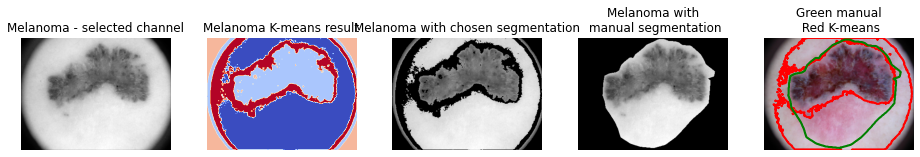

In [ ]:
##Melanoma
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=0

##
max=0
bestmelanomaB = melanoma[:,:,0] 
bestlabels = melanoma[:,:,0] 
bestmask_mel = melanoma[:,:,0] 
bestmask_manual = melanoma[:,:,0] 
bestmask = melanoma[:,:,0]
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 4# choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(4):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(melanomaMask_boolean, 0.5)
    print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestmelanomaB = melanomaB
      bestlabels = labels
      bestmask_mel = mask*melanomaB
      bestmask_manual = melanomaMask_boolean*melanomaB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(4):
  for index2 in range(index1+1,4):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(melanomaMask_boolean, 0.5)
      print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestmask = mask
        bestmelanomaB = melanomaB
        bestlabels = labels
        bestmask_mel = mask*melanomaB
        bestmask_manual = melanomaMask_boolean*melanomaB
for index1 in range(4):
  for index2 in range(index1+1,4):
    for index3 in range(index2+1,4) :
        mask1 = labels==index1
        mask2 = labels==index2
        mask3 = labels==index3
        mask = mask1 + mask2 + mask3 # I  did a + operation because I am sure that a pixel is assigned to a single class.

        contourMask = find_contours(mask, 0.5)
        contourManual = find_contours(melanomaMask_boolean, 0.5)
        print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
        if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
          max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
          bestchannel = channel
          bestmelanomaB = melanomaB
          bestlabels = labels
          bestmask_nev = mask*melanomaB
          bestmask = mask
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_mel,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Channel 1

0.47048563526275133
0.3745800916163746
0.30489167160844566
0.21005210252092
0.6600511232569255
0.5988158105296848
0.47126830941066966
0.54096267079552
0.41192319129188926
0.36665707835394823
0.7384697643933906
0.6029469122426869
0.5613941320430955
0.5189333945445502
The dice score is  0.7384697643933906


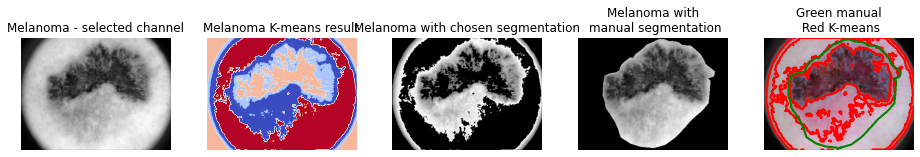

In [ ]:
##Melanoma
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=1

##
max=0
bestmelanomaB = melanoma[:,:,0] 
bestlabels = melanoma[:,:,0] 
bestmask_mel = melanoma[:,:,0] 
bestmask_manual = melanoma[:,:,0] 
bestmask = melanoma[:,:,0]
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 4# choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(4):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(melanomaMask_boolean, 0.5)
    print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestmelanomaB = melanomaB
      bestlabels = labels
      bestmask_mel = mask*melanomaB
      bestmask_manual = melanomaMask_boolean*melanomaB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(4):
  for index2 in range(index1+1,4):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(melanomaMask_boolean, 0.5)
      print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestmask = mask
        bestmelanomaB = melanomaB
        bestlabels = labels
        bestmask_mel = mask*melanomaB
        bestmask_manual = melanomaMask_boolean*melanomaB
for index1 in range(4):
  for index2 in range(index1+1,4):
    for index3 in range(index2+1,4) :
        mask1 = labels==index1
        mask2 = labels==index2
        mask3 = labels==index3
        mask = mask1 + mask2 + mask3 # I  did a + operation because I am sure that a pixel is assigned to a single class.

        contourMask = find_contours(mask, 0.5)
        contourManual = find_contours(melanomaMask_boolean, 0.5)
        print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
        if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
          max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
          bestchannel = channel
          bestmelanomaB = melanomaB
          bestlabels = labels
          bestmask_nev = mask*melanomaB
          bestmask = mask
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_mel,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Channel 2

0.23193708227702237
0.41512603054067165
0.3840904213463052
0.29715703727679776
0.5060391009547908
0.4963594757645101
0.3992462219620184
0.6093954449308869
0.5033792743199261
0.4953956297193657
0.6598464608204538
0.5581784412969816
0.5575946463320096
0.6322304415099939
The dice score is  0.6598464608204538


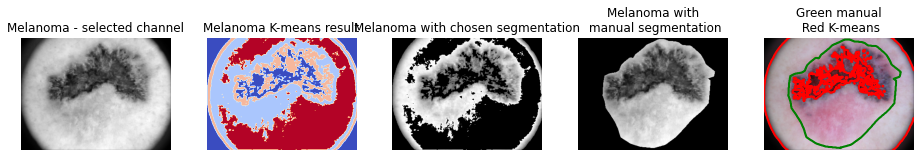

In [ ]:
##Melanoma
# Select a channel (0 for Red, 1 for Green and 2 for Blue)
channel=2

##
max=0
bestmelanomaB = melanoma[:,:,0] 
bestlabels = melanoma[:,:,0] 
bestmask_mel = melanoma[:,:,0] 
bestmask_manual = melanoma[:,:,0] 
bestmask = melanoma[:,:,0]
melanomaB = melanoma[:,:,channel]

# Select the number of cluster K to look for 
K= 4 # choose a number of clusters
##
kmeans=KMeans(n_clusters=K, random_state=1) 
labels=kmeans.fit_predict(melanomaB.reshape(-1,1))
labels=np.reshape(labels,(melanomaB.shape[0],melanomaB.shape[1]))

# Depending on the number of classes K, K-means returns one integer per pixel 
# which indicates the number of the cluster. 
# Choose the integer to use as mask between 0 and K-1

#in this for loop, we will try to find the best result we could obtain without
#combining the clusters
for index in range(4):
    mask=labels==index ## choose which label should be
    contourMask = find_contours(mask, 0.5)
    contourManual = find_contours(melanomaMask_boolean, 0.5)
    print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
    if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
      max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
      bestmask = mask
      bestmelanomaB = melanomaB
      bestlabels = labels
      bestmask_mel = mask*melanomaB
      bestmask_manual = melanomaMask_boolean*melanomaB
#Now we need to verify if we obtain better results by combining 2 clusters 
for index1 in range(4):
  for index2 in range(index1+1,4):
      mask1 = labels==index1
      mask2 = labels==index2
      mask = mask1 + mask2

      contourMask = find_contours(mask, 0.5)
      contourManual = find_contours(melanomaMask_boolean, 0.5)
      print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
      if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
        max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
        bestmask = mask
        bestmelanomaB = melanomaB
        bestlabels = labels
        bestmask_mel = mask*melanomaB
        bestmask_manual = melanomaMask_boolean*melanomaB
for index1 in range(4):
  for index2 in range(index1+1,4):
    for index3 in range(index2+1,4) :
        mask1 = labels==index1
        mask2 = labels==index2
        mask3 = labels==index3
        mask = mask1 + mask2 + mask3 # I  did a + operation because I am sure that a pixel is assigned to a single class.

        contourMask = find_contours(mask, 0.5)
        contourManual = find_contours(melanomaMask_boolean, 0.5)
        print(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)))
        if(1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1)) > max ):
          max = 1-dice(melanomaMask_boolean.reshape(1,-1), mask.reshape(1,-1))
          bestchannel = channel
          bestmelanomaB = melanomaB
          bestlabels = labels
          bestmask_nev = mask*melanomaB
          bestmask = mask
# plot the results
fig = plt.figure(figsize=(16, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 5),
                axes_pad = 0.5)
grid[0].imshow(melanomaB,cmap='gray')
grid[0].set_title('Melanoma - selected channel')
grid[0].axis('off')
grid[1].imshow(bestlabels,cmap='coolwarm')
grid[1].set_title('Melanoma K-means result')
grid[1].axis('off')
grid[2].imshow(bestmask_mel,cmap='gray')
grid[2].set_title('Melanoma with chosen segmentation')
grid[2].axis('off')
grid[3].imshow(melanomaMask_boolean*melanomaB,cmap='gray')
grid[3].set_title('Melanoma with\n manual segmentation')
grid[3].axis('off')
grid[4].imshow(melanoma)
for contour in contourMask:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='r')
for contour in contourManual:
  grid[4].plot(contour[:, 1], contour[:, 0], linewidth=2, c='g')
grid[4].set_title('Green manual\n Red K-means')
grid[4].axis('off')
print('The dice score is ', 1-dice(melanomaMask_boolean.reshape(1,-1), bestmask.reshape(1,-1)))

##Conclusion :    
$=>$For K=4, the best result we obtained is with the green channel. The dice score is equal to 0.73.If we look at the mask for the case of channel one, we can see that there exist ou circle surrounding the lesion which is not really helpful. Maybe we can consider removing it to get better results.

#General conclusion for the melanoma lesion:
After looking at all the results, we can say that we obtained the best dice score while using K=4 and in the green channel.We must also eliminate the circle of the mask so that we are sure to get good results.
It is to mention that the best case is different from what we answered in question 1(best K=4, question1 K=3).

#**Answer Q3:**<br>
To automatically select the class (or unions of classes) representing the skin lesion and not the skin, I thought about selecting the concerned regions according to a threshhold.<br>
In fact, we can compute the average gray level of a region and compare it to the threshhold that we fix.<br>
The choice of the Threshold value can be related to the lesion.In fact,the lesion region is darker than the normal skin. This implementation is way easier i think than the iterative method i did in question 2 while giving the same results.

#**Answer Q4:**<br>
In order to constrain the average to be always one of the observations, we can compute the euclidian distance between the average obtained and the points of our data and then select the point having the least distance from the average and make it the new center of the cluster.